# Combining satellite data with tidal modelling using OTPS <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Description
This notebooks demonstrates how to tidally tag remotely sensed imagery using an external tidal model so that images can be extracted or analysed by tidal stage (e.g. low or high tide). 
This tidal model (OSU Tidal Prediction Software or OTPS) is used to produce datasets including the Intertidal Extents Model (ITEM), High-Low Tide Composites (HLTC), and the National Intertidal Digital Elevation Model (NIDEM).

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [2]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import xarray as xr

sys.path.append('../Scripts')
from dea_plotting import display_map
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_coastaltools import tidal_tag
from dea_coastaltools import tidal_stats

%load_ext autoreload
%autoreload 2

### Connect to the datacube


In [3]:
# Temporary solution to account for Collection 3 data being in a different
# database on the NCI
try:
    dc = datacube.Datacube(app='Tidal_modelling', env='c3-samples')
except:
    dc = datacube.Datacube(app='Tidal_modelling')


In [4]:
query = {'x': (149.4, 149.53),
         'y': (-21.71, -21.85),
         'time': ('1988', '2018'),
         'measurements': ['nbart_red', 'nbart_green', 'nbart_blue'],
         'output_crs': 'EPSG:32755',
         'resolution': (-30, 30),
         'group_by': 'solar_day',
         'dask_chunks': {},
        }

In [5]:
display_map(x=query['x'], y=query['y'])

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## Load satellite time-series

To obtain some satellite data to analyse, we use the `load_ard` import a time series of Landsat 5, 7 and 8 observations as an `xarray.Dataset`.
The input data does not need to be from Landsat: any remotely-sensed imagery with timestamps and spatial coordinates provide enough data to run the tidal model. 

In [6]:
# Load available data from all three Landsat satellites
ds = load_ard(dc=dc,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'],
              ls7_slc_off=False,
              **query)

# Print output data
print(ds)


Loading ga_ls5t_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading ga_ls7e_ard_3 data
    Ignoring SLC-off observations for ls7
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 945 observations as a dask array
<xarray.Dataset>
Dimensions:      (time: 945, x: 458, y: 525)
Coordinates:
  * y            (y) float64 7.597e+06 7.597e+06 ... 7.582e+06 7.582e+06
  * x            (x) float64 7.48e+05 7.481e+05 ... 7.617e+05 7.617e+05
  * time         (time) datetime64[ns] 1988-01-06T23:27:58.301764 ... 2018-12-26T23:58:56.635504
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 525, 458), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 525, 458), meta=np.nda

## Model tide heights for each observation

We use the `tidal_tag` function from `dea_coastaltools` to associate each satellite observation in our timeseries with a tide height.
This function uses the time and date of acquisition and the geographic location of each satellite observation as inputs to the OSU Tidal Prediction Software (OTPS) tidal model.
From [Sagar et al. 2015](https://www.sciencedirect.com/science/article/pii/S0034425717301591):

> The OTPS TPX08 model [consists] of a multi-resolution bathymetric grid solution, with a 1/6° solution in the global open ocean, and a 1/30° local resolution solution to improve modelling in complex shallow water environments (Egbert and Erofeeva, 2010). The OTPS model is based on a system of linear partial differential equations, called Laplace's tidal equations, parametrised with nine harmonic tidal constituents. The model is fitted to track-averaged TOPEX/Poseidon altimeter data collected from 1992 to 2016 and Jason-1 (Poseidon 2) altimeter data from 2002 to 2013, enabling estimation of the tidal height and harmonic constituents at discrete temporal epochs and spatial locations (Egbert and Erofeeva, 2002).

In [7]:
# Model tide heights
ds_tidal = tidal_tag(ds)

# Print output data
print(ds_tidal)


Setting tide modelling location from dataset centroid: 149.47, -21.78
<xarray.Dataset>
Dimensions:      (time: 945, x: 458, y: 525)
Coordinates:
  * y            (y) float64 7.597e+06 7.597e+06 ... 7.582e+06 7.582e+06
  * x            (x) float64 7.48e+05 7.481e+05 ... 7.617e+05 7.617e+05
  * time         (time) datetime64[ns] 1988-01-06T23:27:58.301764 ... 2018-12-26T23:58:56.635504
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 525, 458), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 525, 458), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 525, 458), meta=np.ndarray>
    tide_height  (time) float64 -0.924 1.373 -2.41 3.192 ... -0.812 1.614 -2.192
Attributes:
    crs:      EPSG:32755


The function will automatically select a tide modelling location based on the dataset centroid.
It will then output modelled tide heights as a new `tide_height` variable in the `xarray.Dataset` (the variable should appear under `Data variables` above).

We can easily plot this new variable to inspect the range of tide heights observed by the satellites in our timeseries.
In this example, our observed tide heights range from approximately -3.0 to 4.0 m relative to Mean Sea Level:

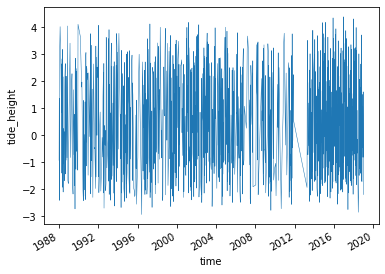

In [14]:
ds_tidal.tide_height.plot(linewidth=0.5)

### Example tide height analysis
To demonstrate how tidally tagged images can be used to produce composites of high and low tide 
imagery, we can compute the lowest 5% and highest 5% percent of tide heights, and use these to filter our observations. 
We can then combine and plot these filtered observations to visualise what the landscape looks like at low and high tide:

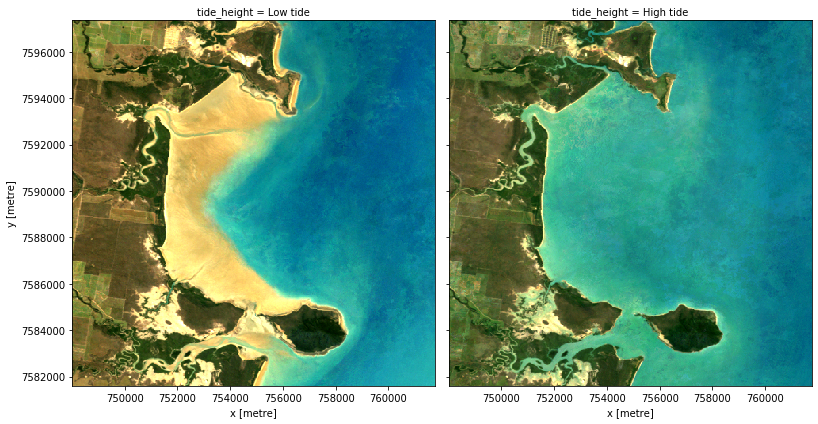

In [70]:
# Calculate the lowest and highest 5% of tides
lowest_5, highest_5 = ds_tidal.tide_height.quantile([0.05, 0.95]).values

# Filter our data to low and high tide observations
filtered_low = ds_tidal.where(ds_tidal.tide_height <= lowest_5, drop=True)
filtered_high = ds_tidal.where(ds_tidal.tide_height >= highest_5, drop=True)

# Take the simple median of each set of low and high tide observations to 
# produce a composite (alternatively, observations could be combined 
# using a geomedian to keep band relationships consistent)
median_low = filtered_low.median(dim='time', keep_attrs=True)
median_high = filtered_high.median(dim='time', keep_attrs=True)

# Combine low and high tide medians into a single dataset and give 
# each layer a meaningful name
ds_highlow = xr.concat([median_low, median_high], dim='tide_height')
ds_highlow['tide_height'] = ['Low tide', 'High tide']

# Plot low and high tide medians side-by-side
rgb(ds_highlow, col='tide_height')

## Modelling ebb and flow tidal phases

In [71]:
# Model tide heights
ds_tidal = tidal_tag(ds, ebb_flow=True)

# Print output data
print(ds_tidal)

Setting tide modelling location from dataset centroid: 149.47, -21.78
Modelling tidal phase (e.g. ebb or flow)
<xarray.Dataset>
Dimensions:      (time: 945, x: 458, y: 525)
Coordinates:
  * y            (y) float64 7.597e+06 7.597e+06 ... 7.582e+06 7.582e+06
  * x            (x) float64 7.48e+05 7.481e+05 ... 7.617e+05 7.617e+05
  * time         (time) datetime64[ns] 1988-01-06T23:27:58.301764 ... 2018-12-26T23:58:56.635504
Data variables:
    nbart_red    (time, y, x) float32 dask.array<chunksize=(1, 525, 458), meta=np.ndarray>
    nbart_green  (time, y, x) float32 dask.array<chunksize=(1, 525, 458), meta=np.ndarray>
    nbart_blue   (time, y, x) float32 dask.array<chunksize=(1, 525, 458), meta=np.ndarray>
    tide_height  (time) float64 -0.924 1.373 -2.41 3.192 ... -0.812 1.614 -2.192
    ebb_flow     (time) <U4 'Flow' 'Ebb' 'Flow' 'Ebb' ... 'Flow' 'Ebb' 'Flow'
Attributes:
    crs:      EPSG:32755


We now have data giving us the both the tide height and tidal phase ('ebb' or 'flow') for every satellite image:

In [77]:
ds_tidal[['time', 'tide_height', 'ebb_flow']].to_dataframe()

,tide_height,ebb_flow
time,,
1988-01-06 23:27:58.301764,-0.924,Flow
1988-01-13 23:34:17.335745,1.373,Ebb
1988-01-22 23:28:16.039754,-2.410,Flow
1988-01-29 23:34:35.316447,3.192,Ebb
1988-02-14 23:34:51.644339,4.031,Flow
...,...,...
2018-11-24 23:58:59.776266,0.743,Flow
2018-12-02 00:05:09.575190,1.068,Ebb
2018-12-10 23:58:56.697928,-0.812,Flow


### Example tide phase analysis

Using tidal phase data, we can also create composites of the landscape during falling and rising tides. 
This may be particularly useful in environments like large tidal flats or mangrove forests where water may remain in the landscape for considerable time after the tidal peak.

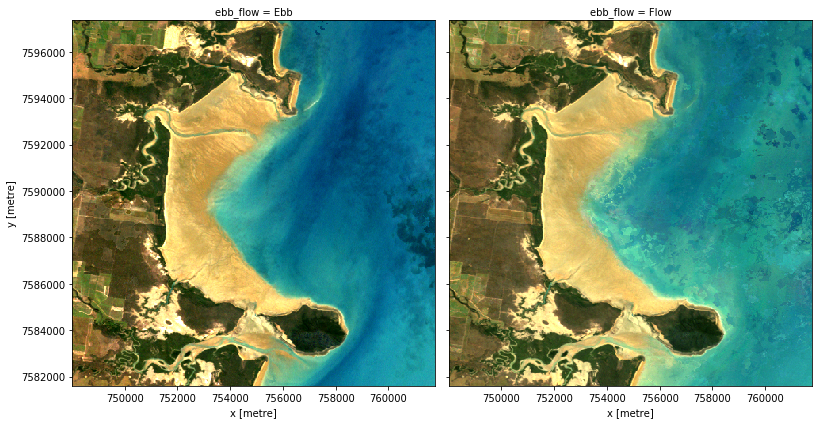

In [100]:
# Extract a subset of low tide observations
ds_low = ds_tidal.where(ds_tidal.tide_height < -2.3, drop=True)

# Create median composites for ebb and flow phases
ds_ebbflow = ds_low.groupby('ebb_flow').median()

# Plot ebb and flow phase medians side-by-side
rgb(ds_ebbflow, col='ebb_flow')

### Modelling tide heights


In [ ]:
out_stats = tidal_stats(ds)

In [ ]:
print(out_stats)

In [ ]:
test = tidal_tag(ds, swap_dims=True)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)